### Section 1: Import Data and Settings

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
path = './'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [5]:
def aggregate_diagnostic(y_dic):
    tmp = []
   #Y
   #  print(y_dic.keys())
    for key in y_dic.keys():
        if key in agg_df.index:
            #print("key", key)
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [6]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

### Section 2: Preprocessing

In [7]:
# variable to remove/set class balancing Section 2.2
balanced =False

#### Section 2.1 Train and Test Split Without any Preprocessing

In [8]:
def split(X, Y):
    test_fold = 10
    # Train
    X_train = X[np.where(Y.strat_fold != test_fold)]
    y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
    # Test
    X_test = X[np.where(Y.strat_fold == test_fold)]
    y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test=split(X, Y)
y_train.shape
X_train.shape

(19601, 1000, 12)

In [51]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer

def encode_filter(X_train, y_train, X_test, y_test, permute, oned):
    # Create label encoding
    unique_classes = list(set([item for sublist in y_train for item in sublist]))
    class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}

    # Filter out data with no labels in y_train and y_test
    y_train_filtered = [labels for labels in y_train if labels]  # Keeps only non-empty labels
    X_train_filtered = X_train[np.array([bool(labels) for labels in y_train])]  # Matches X_train to non-empty labels in y_train

    y_test_filtered = [labels for labels in y_test if labels]  # Keeps only non-empty labels
    X_test_filtered = X_test[np.array([bool(labels) for labels in y_test])]  # Matches X_test to non-empty labels in y_test

    # Re-encode the filtered y_train and y_test
    y_train_encoded = [class_to_idx[labels[0]] for labels in y_train_filtered]
    y_test_encoded = [class_to_idx[labels[0]] for labels in y_test_filtered]

    # Convert filtered X to tensors 
    if permute:
        X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32).unsqueeze(1).permute(0, 3, 2, 1)
        X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32).unsqueeze(1).permute(0, 3, 2, 1)
    else:
        X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32)
    if oned:
        X_train_tensor=X_train_tensor.squeeze(dim=3)
        X_test_tensor=X_test_tensor.squeeze(dim=3)

    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
    print("X_train_tensor shape", X_train_tensor.shape)
    print("X_test_tensor shape", X_test_tensor.shape)

    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    return train_loader, test_loader, y_train_encoded, y_test_encoded, y_train_tensor, X_train_filtered, X_train_tensor, X_test_filtered

In [52]:
train_loader, test_loader, y_train_encoded, y_test_encoded, y_train_tensor, X_train_filtered, X_train_tensor, X_test_filtered=encode_filter(X_train, y_train,  X_test, y_test, permute=True,oned=False)

X_train_tensor shape torch.Size([19230, 12, 1000, 1])
X_test_tensor shape torch.Size([2158, 12, 1000, 1])


#### Section 2.2 Handling Class Imbalance

In [11]:
from sklearn.utils import resample

def undersample_data(X, Y):
    df = pd.DataFrame({'class': Y['diagnostic_superclass'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'), 'index': np.arange(len(Y))})
    grouped = df.groupby('class')
    min_size = grouped.size().min()  # Size of the smallest class

    indices = grouped.apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)['index']
    indices = indices.values

    return X[indices], Y.iloc[indices]

X_balanced, Y_balanced = undersample_data(X, Y)
print(f"Shape of a balanced data: {X_balanced.shape}")


Shape of a balanced data: (2466, 1000, 12)


#### Section 2.3 Artifact Removal

In [12]:
from scipy.signal import butter, filtfilt

def remove_powerline_noise(signal, fs=500, freq=50, Q=30):
    """
    Removes powerline noise using a Notch filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - freq: Frequency to be removed (50 or 60 Hz).
    - Q: Quality factor for the notch filter.
    
    Returns:
    - filtered_signal: Signal with powerline noise removed.
    """
    from scipy.signal import iirnotch

    nyquist = 0.5 * fs
    w0 = freq / nyquist  # Normalize frequency
    b, a = iirnotch(w0, Q)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [13]:

def remove_baseline_wander(signal, fs=500, cutoff=0.5):
    """
    Removes baseline wander using a high-pass filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - cutoff: Cutoff frequency for the high-pass filter.
    
    Returns:
    - filtered_signal: Signal with baseline wander removed.
    """
    nyquist = 0.5 * fs
    b, a = butter(1, cutoff / nyquist, btype='high')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


In [14]:
def remove_high_frequency_noise(signal, fs=500, cutoff=40):
    """
    Removes high-frequency noise using a low-pass filter.
    
    Args:
    - signal: 1D array, ECG signal.
    - fs: Sampling frequency.
    - cutoff: Cutoff frequency for the low-pass filter.
    
    Returns:
    - filtered_signal: Signal with high-frequency noise removed.
    """
    nyquist = 0.5 * fs
    b, a = butter(1, cutoff / nyquist, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [15]:
def clean_ecg_data(X, fs=500):
    """
    Cleans a 3D ECG dataset (samples, time steps, leads) by removing artifacts.
    
    Args:
    - X: 3D array of shape (num_samples, signal_length, 12).
    - fs: Sampling frequency.
    
    Returns:
    - X_clean: 3D array of cleaned ECG data.
    """
    num_samples, signal_length, num_leads = X.shape
    X_clean = np.zeros_like(X)

    for sample_idx in range(num_samples):
        if sample_idx%1000==0:
            print("Sample_index:", sample_idx)
        for lead_idx in range(num_leads):
            signal = X[sample_idx, :, lead_idx]
            
            # Remove baseline wander
            signal = remove_baseline_wander(signal, fs=fs)
            # Remove powerline noise
            signal = remove_powerline_noise(signal, fs=fs, freq=50)  # Use 60 Hz for US data
            # Remove high-frequency noise
            signal = remove_high_frequency_noise(signal, fs=fs)

            # Store cleaned signal
            X_clean[sample_idx, :, lead_idx] = signal

    return X_clean


In [16]:
# clean the data
if balanced:
    X_cleaned = clean_ecg_data(X_balanced, fs=sampling_rate)
else:
    X_cleaned = clean_ecg_data(X, fs=sampling_rate)

if balanced:
    Y_cleaned=Y_balanced.copy()
else:
    Y_cleaned=Y.copy()


Sample_index: 0
Sample_index: 1000
Sample_index: 2000
Sample_index: 3000
Sample_index: 4000
Sample_index: 5000
Sample_index: 6000
Sample_index: 7000
Sample_index: 8000
Sample_index: 9000
Sample_index: 10000
Sample_index: 11000
Sample_index: 12000
Sample_index: 13000
Sample_index: 14000
Sample_index: 15000
Sample_index: 16000
Sample_index: 17000
Sample_index: 18000
Sample_index: 19000
Sample_index: 20000
Sample_index: 21000


In [ ]:
X_train_clean, y_train_clean, X_test_clean, y_test_clean=split(X_cleaned, Y_cleaned)
y_train_clean.shape
X_train_clean.shape
train_loader_clean, test_loader_clean, y_train_encoded_clean, y_test_encoded_clean, y_train_tensor_clean, X_train_filtered_clean, X_train_tensor_clean, X_test_filtered_clean=encode_filter(X_train_clean, y_train_clean,  X_test_clean, y_test_clean, permute=True, oned=False)

X_train_tensor shape torch.Size([19230, 12, 1000, 1])
X_test_tensor shape torch.Size([2158, 12, 1000, 1])


In [ ]:
train_loader_clean_1d, test_loader_clean_1d, y_train_encoded_clean, y_test_encoded_clean, y_train_tensor_clean, X_train_filtered_clean_1d, X_train_tensor_clean_1d, X_test_filtered_clean_1d=encode_filter(X_train_clean, y_train_clean,  X_test_clean, y_test_clean, permute=True, oned=True)

X_train_tensor shape torch.Size([19230, 12, 1000])
X_test_tensor shape torch.Size([2158, 12, 1000])


#### Section 2.4 Convert ECG Time series data to Spectrum to 2D image


In [19]:
from scipy.signal import stft

def ecg_to_spectrogram(ecg_signal, sampling_rate, nperseg=256, noverlap=None):
    """
    Converts a 1D ECG signal into a spectrogram using STFT.

    Args:
    - ecg_signal: 1D array, the ECG time-series signal.
    - fs: Sampling frequency.
    - nperseg: Number of samples per segment for STFT.
    - noverlap: Number of overlapping samples (default: None, usually nperseg//2).

    Returns:
    - f: Frequency bins.
    - t: Time bins.
    - Sxx: Spectrogram magnitude.
    """
    f, t, Zxx = stft(ecg_signal, fs=sampling_rate, nperseg=nperseg, noverlap=noverlap)
    Sxx = np.abs(Zxx)  # Magnitude of the complex STFT
    return f, t, Sxx

In [20]:
import os

def process_all_samples(X, fs=500, save_images=False, output_dir="./spectrograms"):
    """
    Converts all ECG samples in X to spectrograms for 12 leads.

    Args:
    - X: 3D array of shape (num_samples, signal_length, 12).
    - fs: Sampling frequency.
    
    Returns:
    - all_spectrograms: List of spectrograms for all samples. 
      Shape: [(12, frequency_bins, time_bins) for each sample].
    """
    if save_images and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_spectrograms = []
    
    for sample_idx in range(X.shape[0]):
        sample_ecg = X[sample_idx]  # Shape: (signal_length, 12)
        sample_spectrograms = []
        if sample_idx%1000==0:
            print("Sample_index:", sample_idx)
        # Process each lead
        for lead in range(sample_ecg.shape[1]):
            ecg_signal = sample_ecg[:, lead]
            f, t, Sxx = ecg_to_spectrogram(ecg_signal, sampling_rate=sampling_rate)
            sample_spectrograms.append(Sxx)

        all_spectrograms.append(np.array(sample_spectrograms))  # Shape: (12, frequency_bins, time_bins)
    return all_spectrograms

In [21]:
all_spectrograms = process_all_samples(X_cleaned, sampling_rate)


# Print the shape of processed spectrograms
print(f"Processed {len(all_spectrograms)} samples with spectrograms for 12 leads.")
print(f"Shape of a single sample spectrogram: {all_spectrograms[0].shape}")

Sample_index: 0
Sample_index: 1000
Sample_index: 2000
Sample_index: 3000
Sample_index: 4000
Sample_index: 5000
Sample_index: 6000
Sample_index: 7000
Sample_index: 8000
Sample_index: 9000
Sample_index: 10000
Sample_index: 11000
Sample_index: 12000
Sample_index: 13000
Sample_index: 14000
Sample_index: 15000
Sample_index: 16000
Sample_index: 17000
Sample_index: 18000
Sample_index: 19000
Sample_index: 20000
Sample_index: 21000
Processed 21799 samples with spectrograms for 12 leads.
Shape of a single sample spectrogram: (12, 129, 9)


#### Section 2.5  Train and Test Split After Preprocessing Steps - 2.2 to 2.4

In [22]:
test_fold = 10

# Split into train and test based on strat_fold
# Extracting only one lead (e.g., lead 0)
X_train_spec = np.array([all_spectrograms[i] for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold != test_fold])
y_train_spec = [Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold != test_fold]

X_test_spec = np.array([all_spectrograms[i] for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold == test_fold])
y_test_spec = [Y_cleaned.iloc[i].diagnostic_superclass for i in range(len(Y_cleaned)) if Y_cleaned.iloc[i].strat_fold == test_fold]


In [23]:
y_train_spec
X_train_spec.shape

(19601, 12, 129, 9)

In [ ]:
train_loader_spec, test_loader_spec, y_train_encoded_spec, y_test_encoded_spec, y_train_tensor_spec, X_train_filtered_spec, X_train_tensor_spec, X_test_filtered_spec=encode_filter(X_train_spec, y_train_spec,  X_test_spec, y_test_spec, permute=False,  oned=False)

X_train_tensor shape torch.Size([19230, 12, 129, 9])
X_test_tensor shape torch.Size([2158, 12, 129, 9])


### Section 3: Visualization

#### Section 3.1: Plot multiple ECG signals in subplots

In [25]:
import matplotlib.pyplot as plt

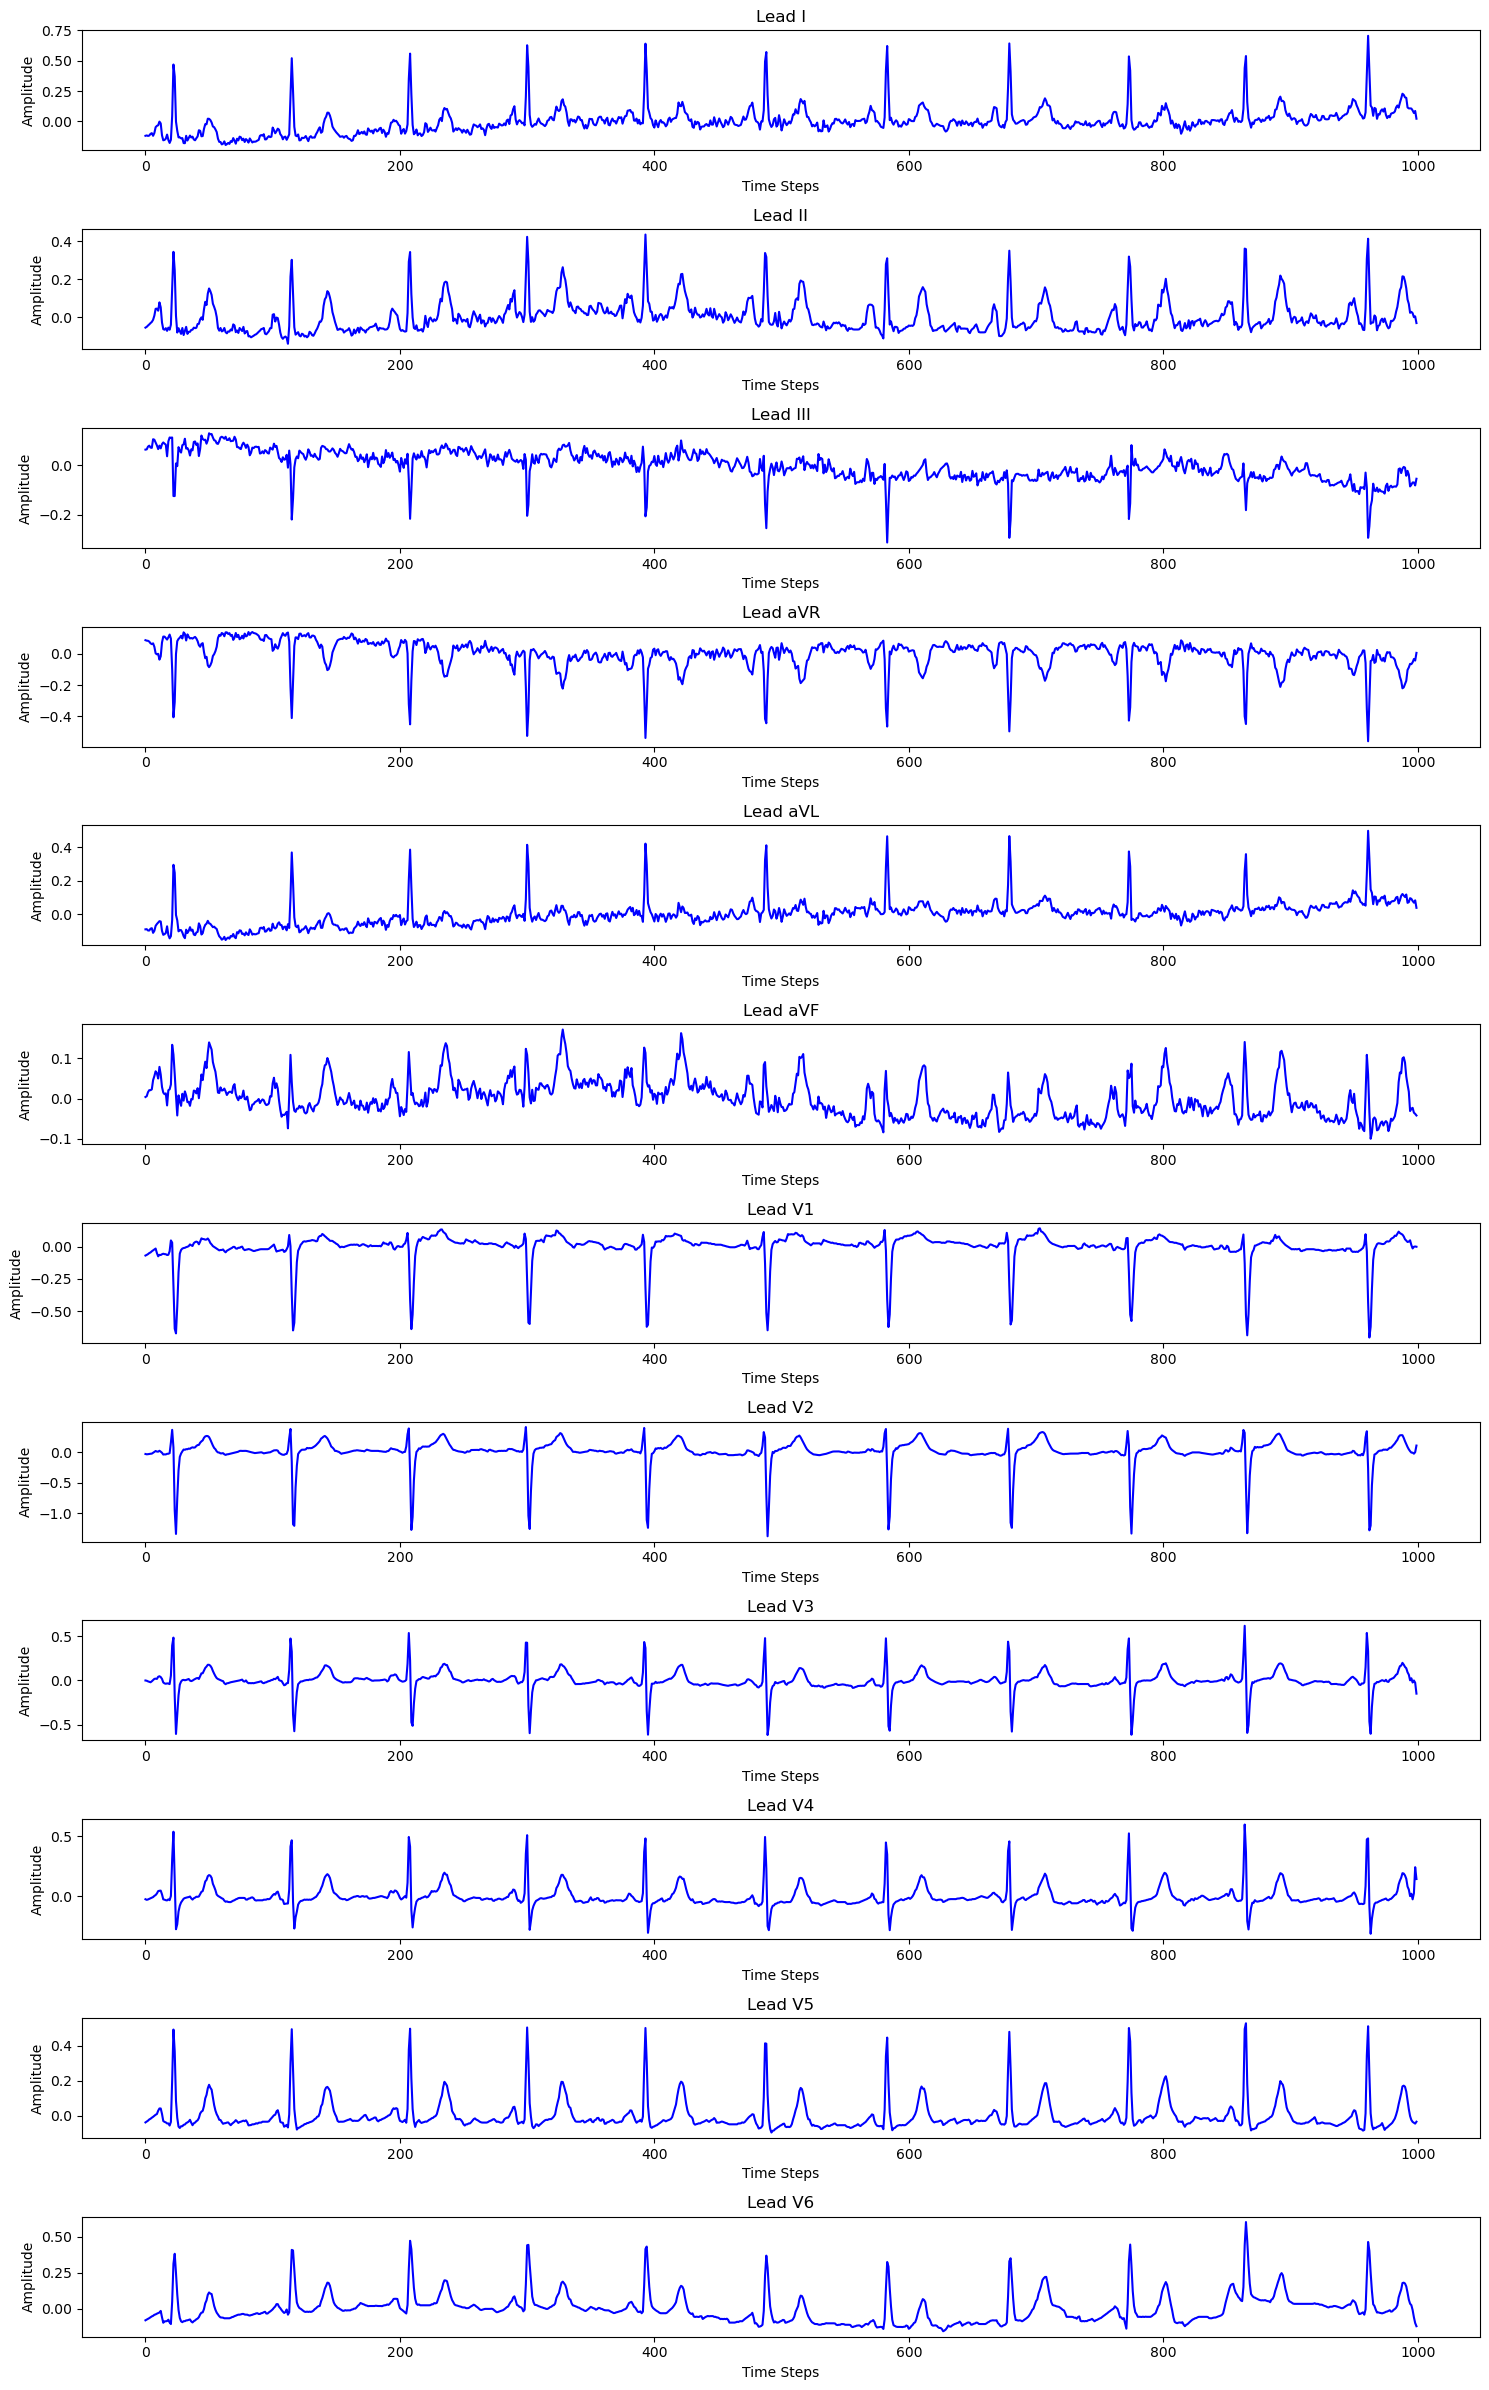

In [26]:
# Plot 12 channnels of first sample - original data
def plot_12_lead_ecg(ecg_data, sample_index=0, lead_names=None):
    if lead_names is None:
        lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    signal = ecg_data[sample_index]  
    num_leads = signal.shape[1]  
    
    plt.figure(figsize=(15, num_leads * 2))
    for lead in range(num_leads):
        plt.subplot(num_leads, 1, lead + 1)
        plt.plot(signal[:, lead], color='b')
        plt.title(f"Lead {lead_names[lead]}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.show()

plot_12_lead_ecg(X, sample_index=0)


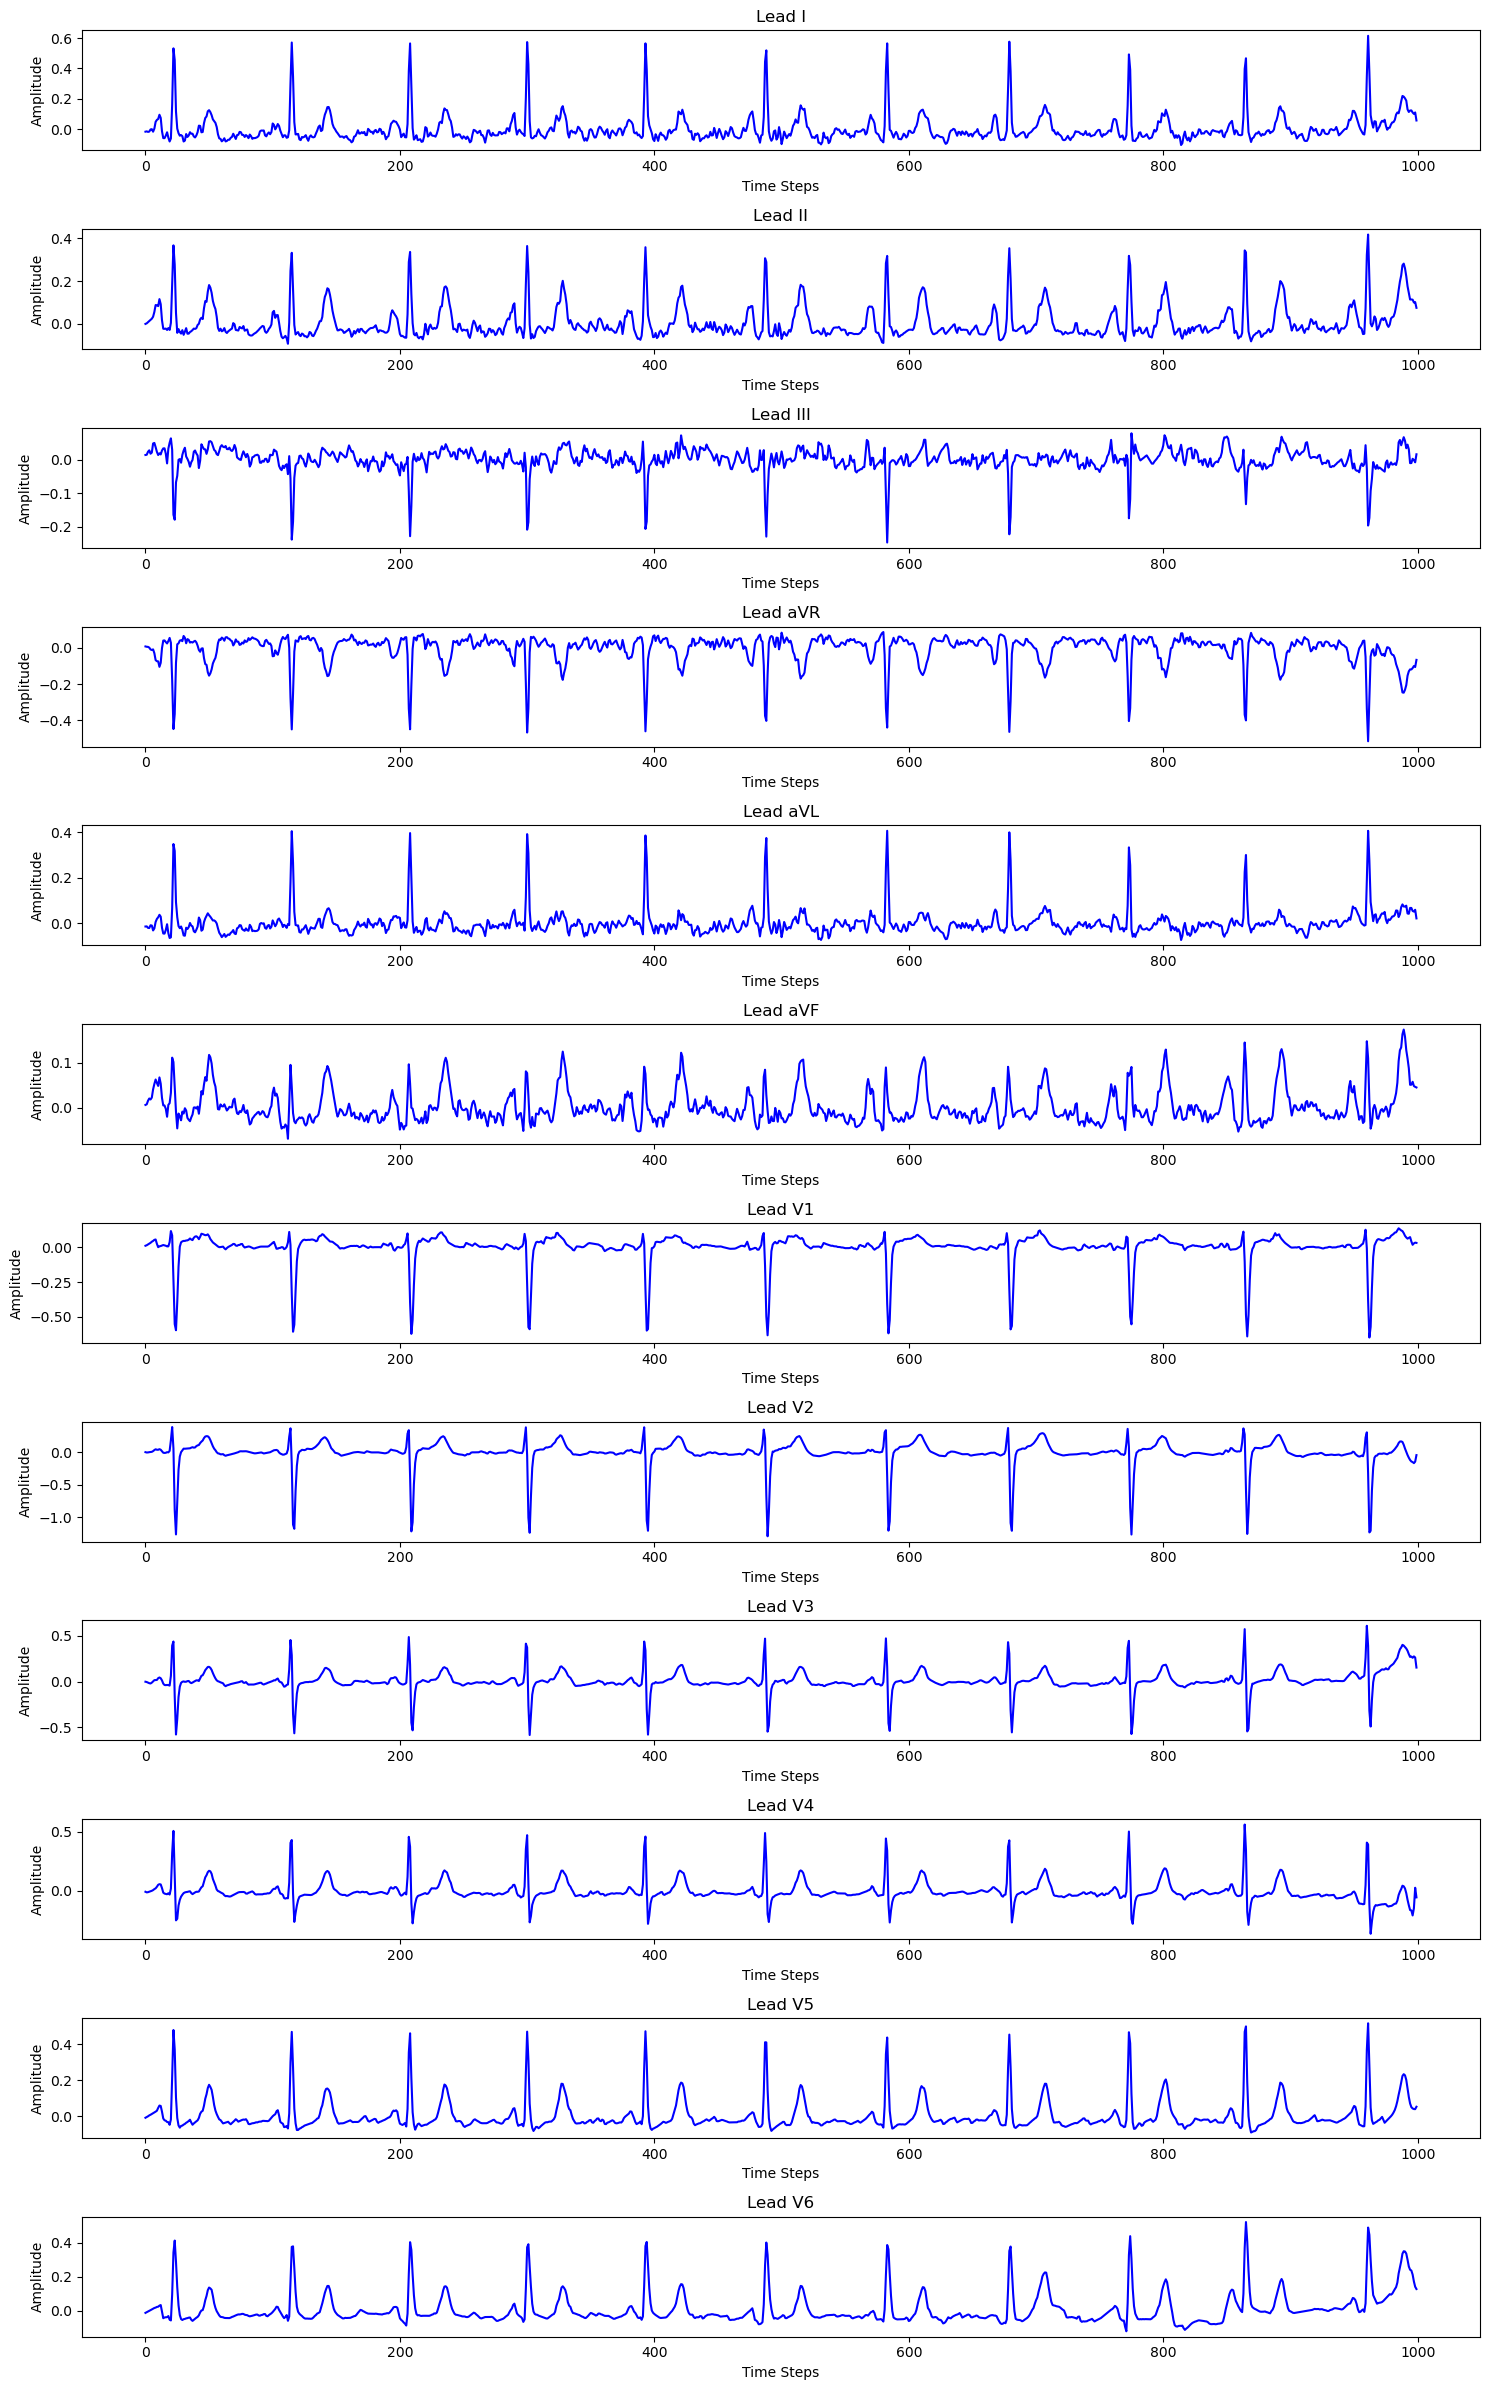

In [29]:
# Plot 12 channnels of first sample - Artifact cleaned data
plot_12_lead_ecg(X_cleaned, sample_index=0)

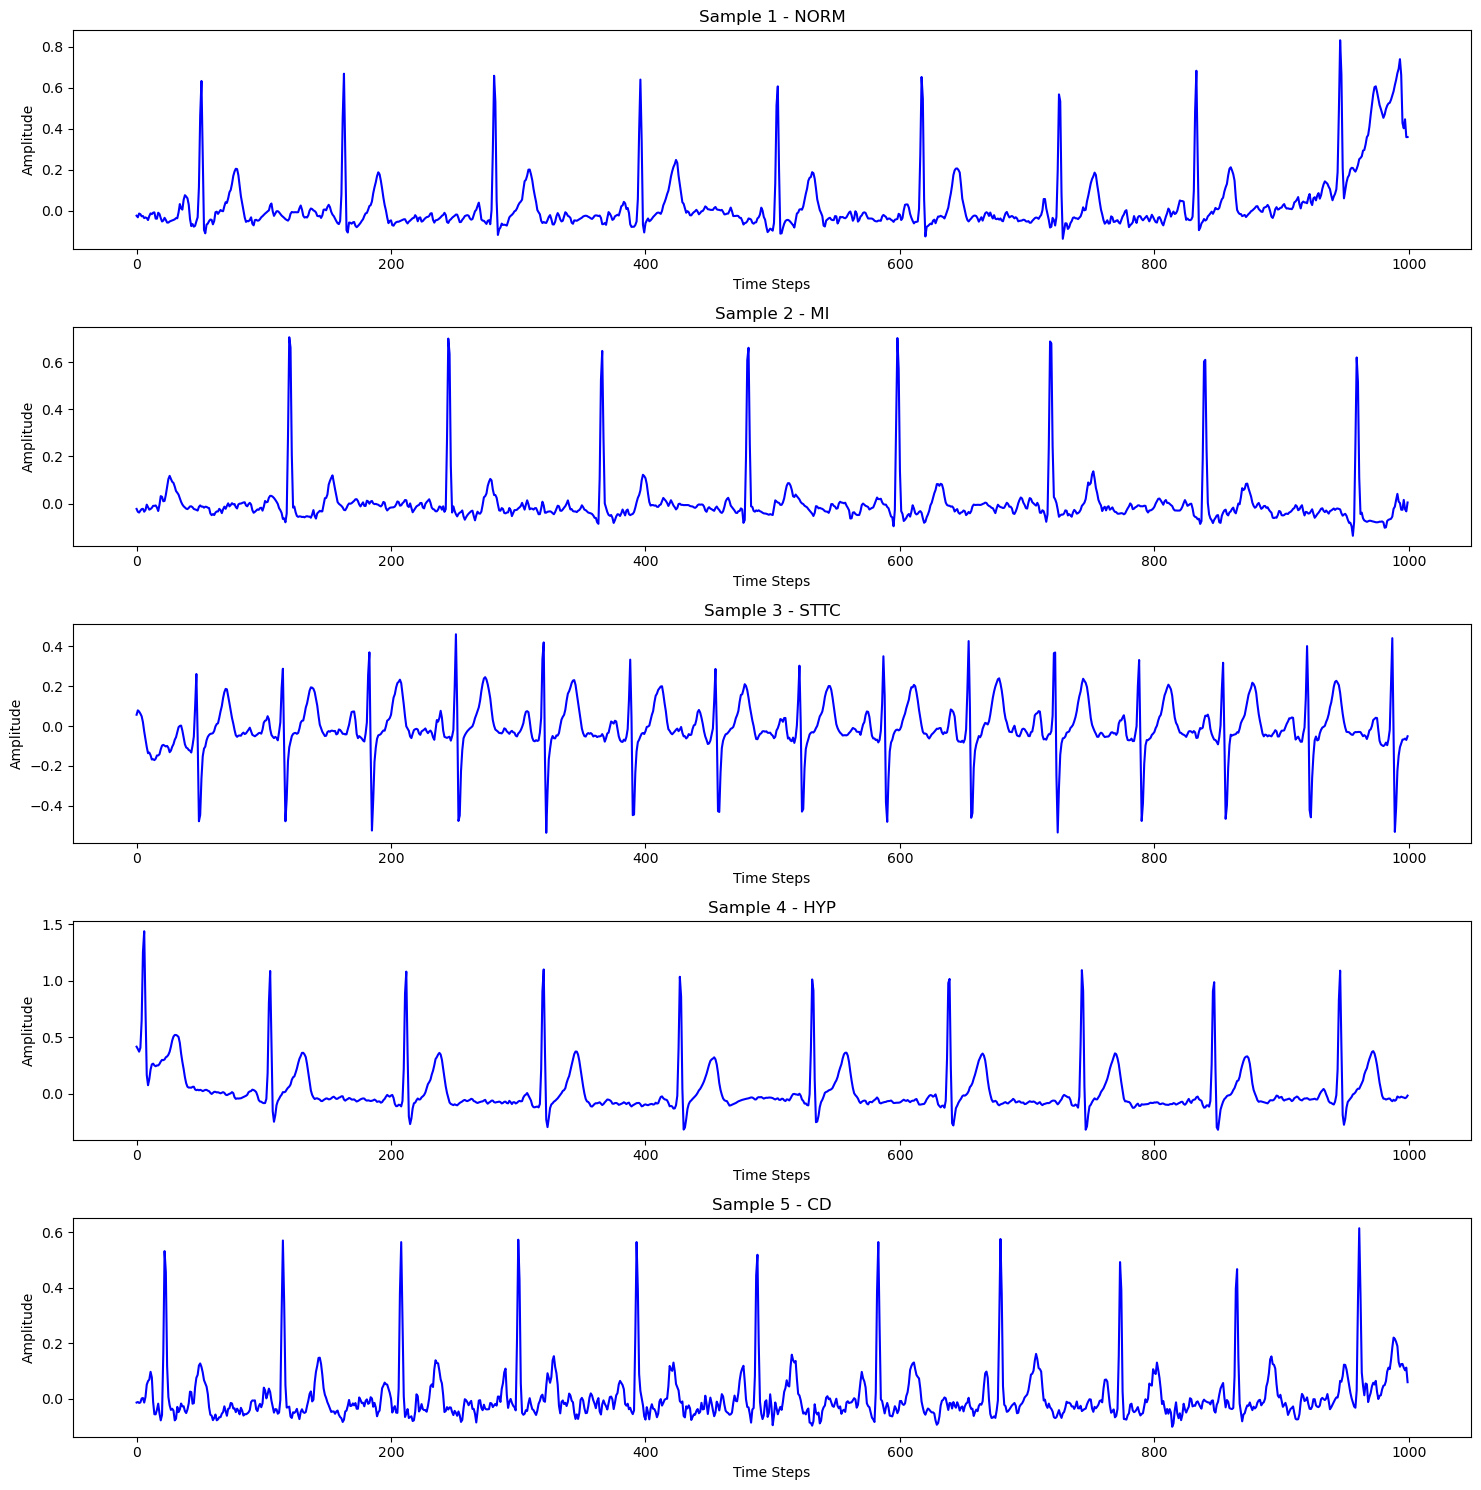

In [31]:
# Plot channel 1 of the sample of each class on balanced cleaned data

def plot_samples_with_classes(X, classes, num_samples=5, unique_classes=None):
    
    plt.figure(figsize=(15, num_samples * 3))
    for i, cls in enumerate(unique_classes[:num_samples]):
        idx = np.where(classes == cls)[0][0]  
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(X[idx][:,0], color='b')
        label = cls
        plt.title(f"Sample {i+1} - {label}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.show()

plot_samples_with_classes(
    X_cleaned, 
    Y_balanced['diagnostic_superclass'].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown'
    ),
    num_samples=5, 
    unique_classes=["NORM", "MI", "STTC", "HYP", "CD"]
)




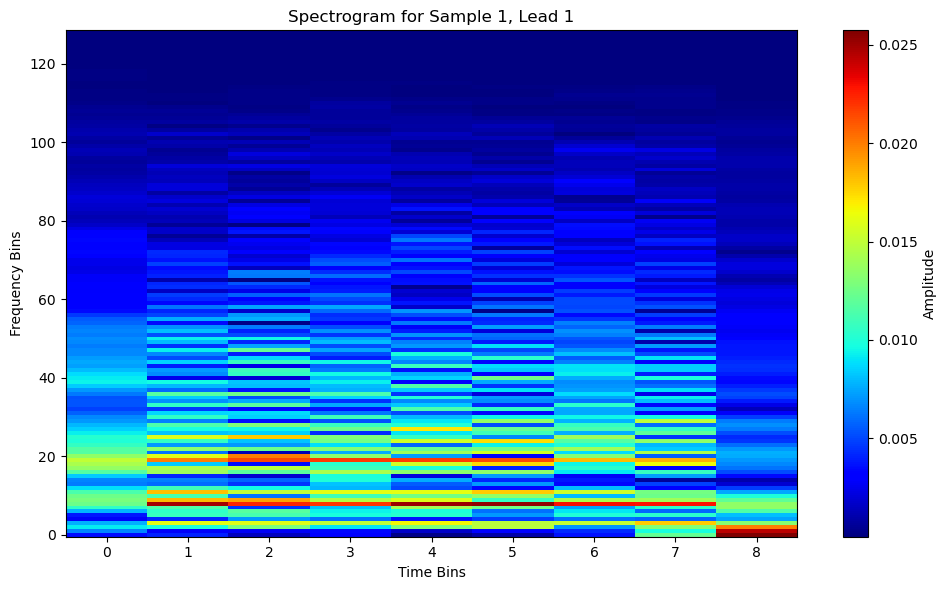

In [32]:
# Plot Spectrograms generated in section 2.4
def plot_spectrogram(spectrogram, sample_idx, lead_idx):
    """
    Plots a spectrogram for a specific sample and lead.
    
    Args:
    - spectrogram: List of spectrograms for all samples.
    - sample_idx: Index of the sample to plot.
    - lead_idx: Index of the lead to plot (0-11 for 12 leads).
    """
    spectrogram_data = spectrogram[sample_idx][lead_idx]  # Extract the specific lead's spectrogram

    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram_data, aspect='auto', origin='lower', cmap='jet')
    plt.title(f"Spectrogram for Sample {sample_idx + 1}, Lead {lead_idx + 1}")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Time Bins")
    plt.colorbar(label="Amplitude")
    plt.tight_layout()
    plt.show()

plot_spectrogram(all_spectrograms, sample_idx=0, lead_idx=0)


#### Section 3.2: Class Distribution of diagnostic_superclass

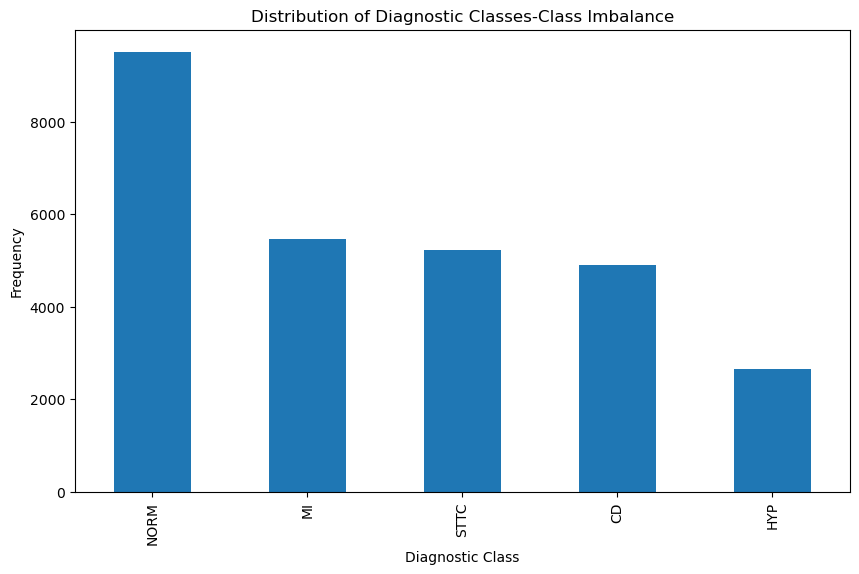

In [33]:
#Plot class distribution of imbalanced data
def plot_class_distribution(Y, plot_name):
    class_counts = Y['diagnostic_superclass'].explode().value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title("Distribution of Diagnostic Classes-"+ plot_name)
    plt.xlabel("Diagnostic Class")
    plt.ylabel("Frequency")
    plt.show()

plot_class_distribution(Y, "Class Imbalance")

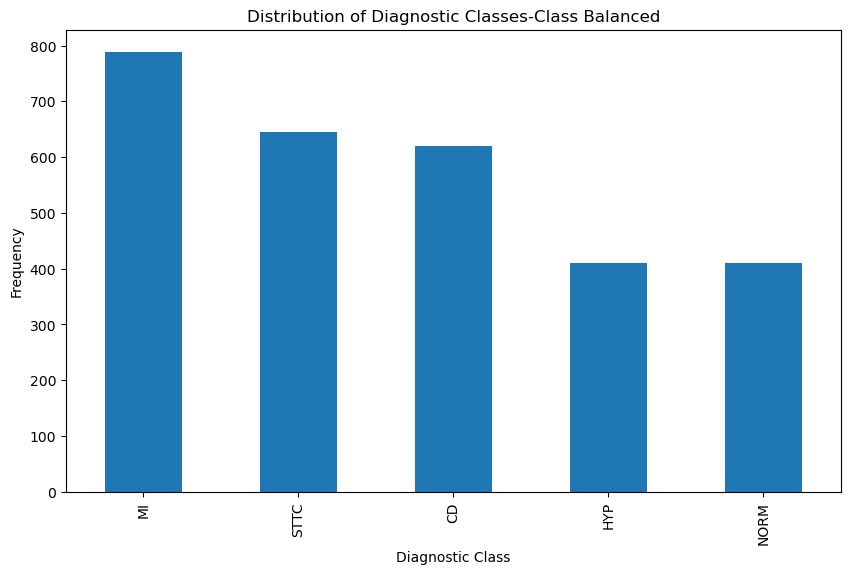

In [34]:
#Plot class distribution of balanced data
plot_class_distribution(Y_balanced, "Class Balanced")

#### Section 3.3 Demographic and Gender Distribution

In [35]:
import seaborn as sns

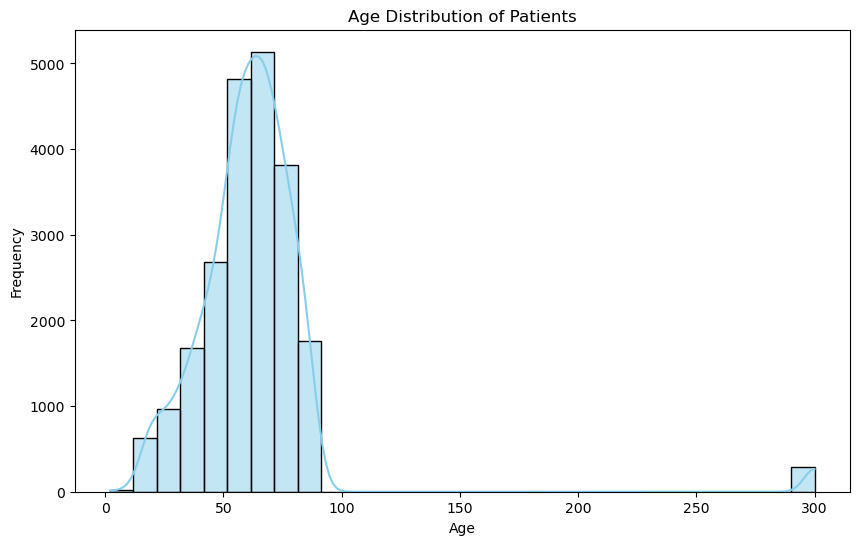

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(Y['age'], kde=True, bins=30, color='skyblue')
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_4083791/1404388577.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sex', data=Y, palette='Set2')


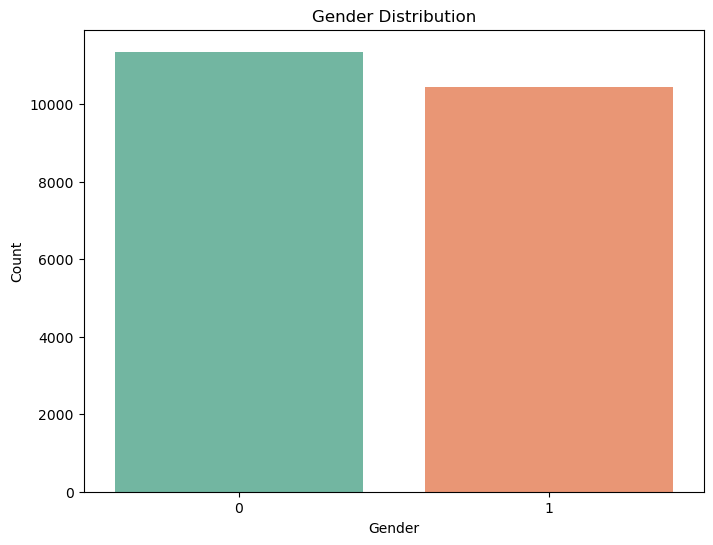

In [37]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', data=Y, palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

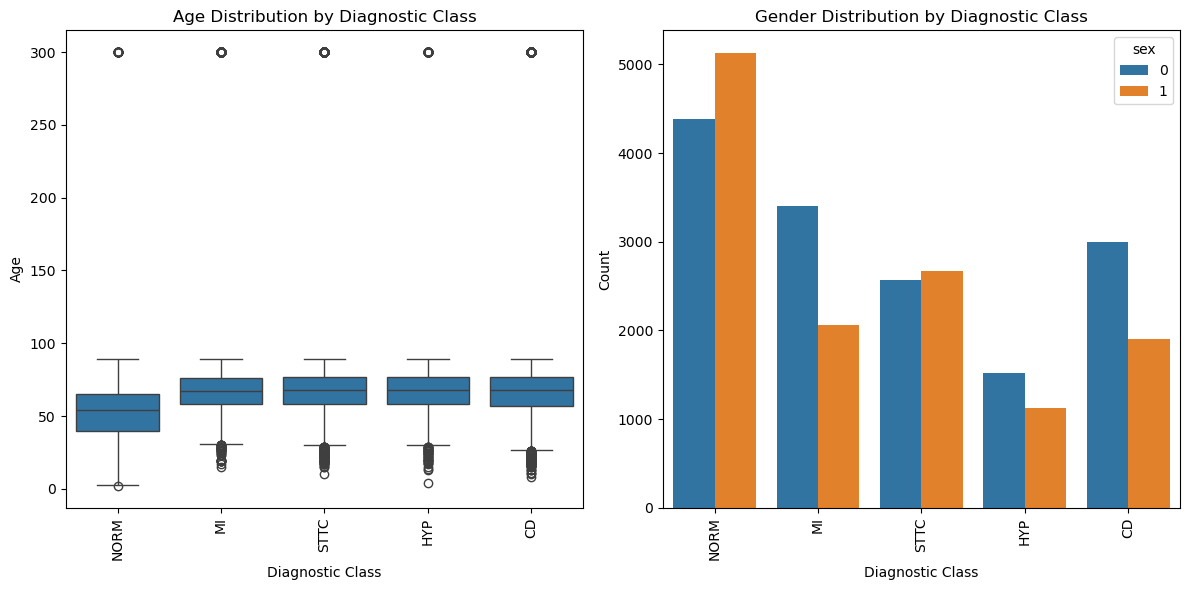

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

Y_exploded = Y.explode('diagnostic_superclass').reset_index(drop=True)

def plot_age_gender_distribution(Y):
    plt.figure(figsize=(12, 6))

    # Plot age distribution for each diagnostic class
    plt.subplot(1, 2, 1)
    sns.boxplot(data=Y, x='diagnostic_superclass', y='age')
    plt.title('Age Distribution by Diagnostic Class')
    plt.xlabel('Diagnostic Class')
    plt.ylabel('Age')
    plt.xticks(rotation=90)

    # Plot gender distribution by diagnostic class
    plt.subplot(1, 2, 2)
    sns.countplot(data=Y, x='diagnostic_superclass', hue='sex')
    plt.title('Gender Distribution by Diagnostic Class')
    plt.xlabel('Diagnostic Class')
    plt.ylabel('Count')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

plot_age_gender_distribution(Y_exploded)

#### Section 3.4: Feature Importance

In [39]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

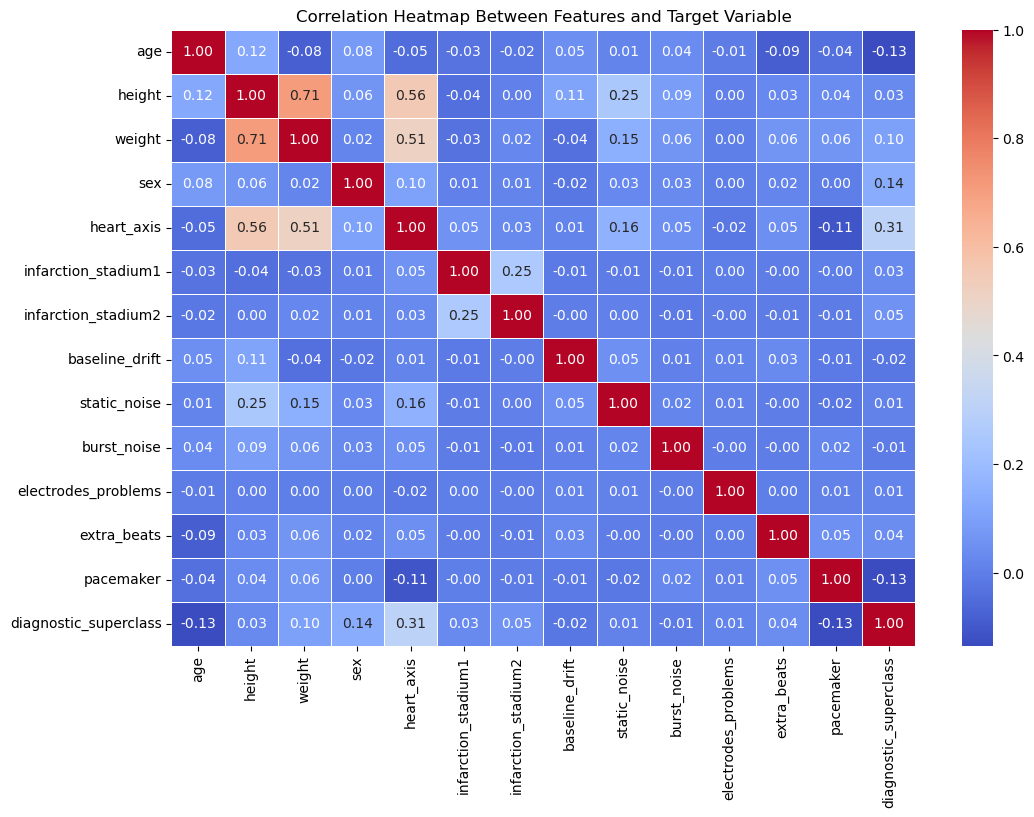

In [40]:
from sklearn.preprocessing import LabelEncoder

# Select numerical columns and check for non-numeric columns that may cause issues
numerical_columns = ['age', 'height', 'weight','sex']

Y_filled = Y.copy()
Y_filled[numerical_columns] = Y_filled[numerical_columns].fillna(0)

# Identify and exclude any non-numeric columns, encode categorical columns using label encoding or one-hot encoding
categorical_columns = ['heart_axis',  'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
                        'extra_beats', 'pacemaker', 'diagnostic_superclass']  

# For categorical columns, replace NaNs with 'no'
Y_filled[categorical_columns] = Y_filled[categorical_columns].fillna('no')

# Convert categorical columns to numeric representations

encoder = LabelEncoder()
for col in categorical_columns:
    Y_filled[col] = encoder.fit_transform(Y_filled[col].astype(str))

# Compute the correlation matrix on the numerical data only
corr_matrix = Y_filled[numerical_columns + categorical_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap Between Features and Target Variable")
plt.show()


/tmp/ipykernel_4083791/2232586419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.index, y=top_10_features.values, palette='coolwarm')


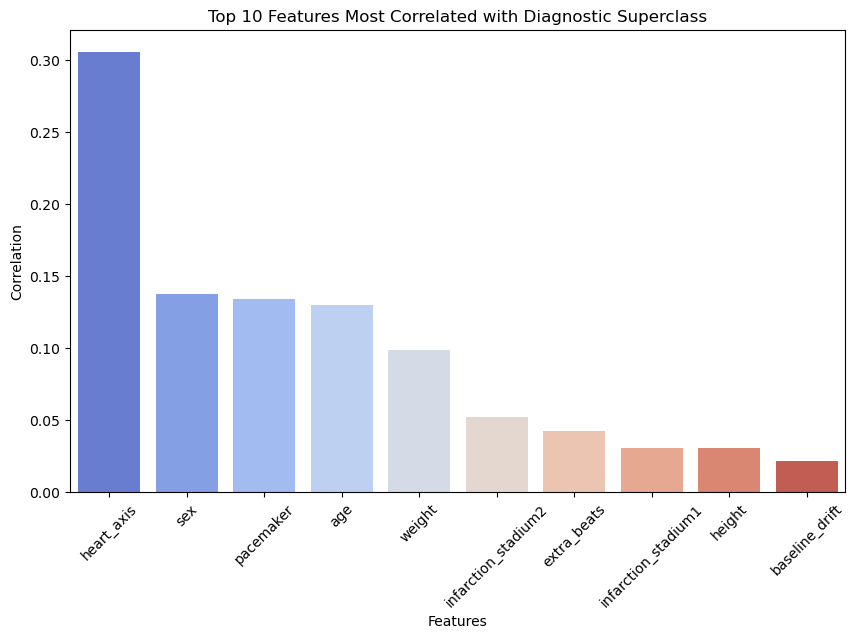

Top 10 features most correlated with diagnostic_superclass:
heart_axis             0.305726
sex                    0.137914
pacemaker              0.134113
age                    0.129947
weight                 0.098698
infarction_stadium2    0.051966
extra_beats            0.042472
infarction_stadium1    0.030750
height                 0.030334
baseline_drift         0.021578
Name: diagnostic_superclass, dtype: float64


In [41]:
# Get the correlation of each feature with diagnostic_superclass_numeric
correlation_with_target = corr_matrix['diagnostic_superclass'].drop('diagnostic_superclass')

# Get the top 10 most correlated features
top_10_features = correlation_with_target.abs().sort_values(ascending=False).head(10)

# Plot the top 10 most correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.index, y=top_10_features.values, palette='coolwarm')
plt.title("Top 10 Features Most Correlated with Diagnostic Superclass")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.show()

# Display the top 10 features
print("Top 10 features most correlated with diagnostic_superclass:")
print(top_10_features)

### Section 4: Train data using different models

#### Section 4.0 Generic Functions

In [42]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
def print_info_data(y_train_tensor, model, y_train_encoded, y_test_encoded, X_train_filtered):
    num_classes = len(set(y_train_tensor.tolist()))
    print(f"Number of classes: {num_classes}")
    print(f"Output layer size: {model.fc.out_features}")
    print("Unique encoded labels in y_train:", set(y_train_encoded))
    print("Unique encoded labels in y_test:", set(y_test_encoded))
    print("Length of X_train_filtered:", len(X_train_filtered))
    print("Length of y_train_encoded:", len(y_train_encoded))

In [44]:
def train_model(model, train_loader, device):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    num_epochs = 40
    training_losses=[]
    accuracies=[]
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss=running_loss/len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

        training_losses.append(train_loss)
        accuracies.append(100 * correct / total)
    
    return training_losses, accuracies

In [45]:
def plot_loss_accuracy(training_losses, accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.title('Training Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(len(training_losses))) 
    plt.grid()
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(accuracies, label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(accuracies))) 
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
# Evaluation on test set

def test_model(model, test_loader, device):

    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())  # Append true labels
            y_pred.extend(predicted.cpu().numpy())  # Append predicted labels

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Convert to numpy arrays for sklearn metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
    f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

    # Print classification report (includes precision, recall, F1 for each class)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Test Accuracy (for reference)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

#### Section 4.1: Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [53]:
# Flatten and standardize data (assuming X_train and X_test are in shape [samples, time_steps])
X_train_flat = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_flat = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Optionally apply PCA to reduce dimensionality (e.g., reduce to 50 components)
pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)


In [54]:
# Initialize and train logistic regression
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_reg.fit(X_train_reduced, y_train_encoded)

# Predict and evaluate on test data
y_pred = log_reg.predict(X_test_reduced)

# Print precision, recall, and F1-score for each class with zero_division parameter
precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)  # Set zero_division to 0 for ill-defined precision
recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)  # Set zero_division to 0 for ill-defined recall
f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)  # Set zero_division to 0 for ill-defined F1-score

# Displaying metrics for each class
print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1 Score: {f1:.2f}")

# Print accuracy and classification report
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred,zero_division=0))

Overall Precision: 0.32
Overall Recall: 0.45
Overall F1 Score: 0.28
Test Accuracy: 44.86%

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       256
           1       0.45      1.00      0.62       963
           2       0.00      0.00      0.00       362
           3       0.83      0.02      0.03       317
           4       0.00      0.00      0.00       260

    accuracy                           0.45      2158
   macro avg       0.26      0.20      0.13      2158
weighted avg       0.32      0.45      0.28      2158



#### Section 4.2: Resnet

In [55]:
def update_resnet_model(y_train_tensor):
    # Load pre-trained ResNet model and modify for single-channel ECG data
    resnet = models.resnet18(pretrained=True)

    # Modify the first convolution layer to accept single channel input
    resnet.conv1 = nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


    # Modify the fully connected layer to match the number of diagnostic classes
    num_classes = len(y_train_tensor.unique())  # or use a fixed number if known
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

    return resnet

##### Section 4.2.1 Resnet on raw ECG data

In [56]:
model_resnet = update_resnet_model(y_train_tensor)
# Move model to device
model_resnet.to(device)
print(model_resnet)

/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [57]:
print_info_data(y_train_tensor, model_resnet, y_train_encoded, y_test_encoded, X_train_filtered)

Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 19230
Length of y_train_encoded: 19230


In [58]:
training_losses_resnet, accuracies_resnet=train_model(model_resnet, train_loader, device)

Epoch [1/40], Loss: 0.9440, Accuracy: 65.67%
Epoch [2/40], Loss: 0.8217, Accuracy: 70.49%
Epoch [3/40], Loss: 0.7783, Accuracy: 71.11%
Epoch [4/40], Loss: 0.7433, Accuracy: 72.48%
Epoch [5/40], Loss: 0.7164, Accuracy: 73.46%
Epoch [6/40], Loss: 0.6964, Accuracy: 74.15%
Epoch [7/40], Loss: 0.6786, Accuracy: 74.72%
Epoch [8/40], Loss: 0.6553, Accuracy: 75.04%
Epoch [9/40], Loss: 0.6381, Accuracy: 76.04%
Epoch [10/40], Loss: 0.6255, Accuracy: 76.51%
Epoch [11/40], Loss: 0.6105, Accuracy: 76.86%
Epoch [12/40], Loss: 0.5796, Accuracy: 77.87%
Epoch [13/40], Loss: 0.5538, Accuracy: 78.94%
Epoch [14/40], Loss: 0.5311, Accuracy: 80.10%
Epoch [15/40], Loss: 0.4848, Accuracy: 81.48%
Epoch [16/40], Loss: 0.4443, Accuracy: 83.32%
Epoch [17/40], Loss: 0.3993, Accuracy: 84.77%
Epoch [18/40], Loss: 0.3466, Accuracy: 87.03%
Epoch [19/40], Loss: 0.2875, Accuracy: 89.19%
Epoch [20/40], Loss: 0.2581, Accuracy: 90.34%
Epoch [21/40], Loss: 0.2129, Accuracy: 91.87%
Epoch [22/40], Loss: 0.1907, Accuracy: 92.8

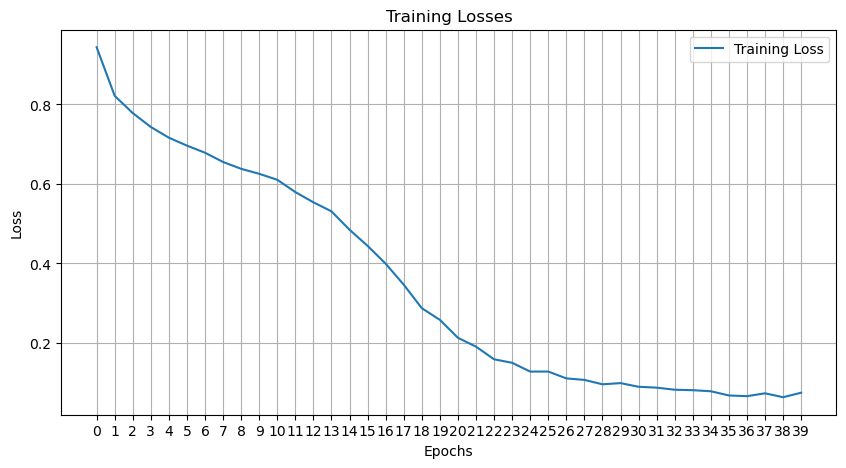

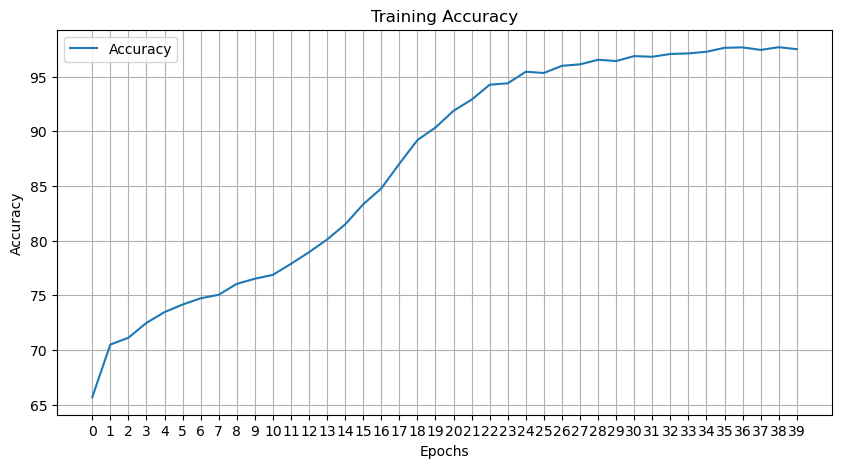

In [59]:
plot_loss_accuracy(training_losses_resnet, accuracies_resnet)

In [60]:
test_model(model_resnet, test_loader, device)

Precision: 0.6648
Recall: 0.6724
F1 Score: 0.6671

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.43      0.45       256
           1       0.80      0.86      0.83       963
           2       0.55      0.59      0.57       362
           3       0.63      0.54      0.58       317
           4       0.55      0.49      0.52       260

    accuracy                           0.67      2158
   macro avg       0.60      0.58      0.59      2158
weighted avg       0.66      0.67      0.67      2158

Test Accuracy: 67.24%


##### Section 4.2.2 Resnet with Spectrograms

In [61]:
model_spec = update_resnet_model(y_train_tensor_spec)
# Move model to device
model_spec.to(device)
print(model_spec)

ResNet(
  (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nalla052/.conda/envs/my-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
print_info_data(y_train_tensor_spec, model_spec, y_train_encoded_spec, y_test_encoded_spec, X_train_filtered_spec)

Number of classes: 5
Output layer size: 5
Unique encoded labels in y_train: {0, 1, 2, 3, 4}
Unique encoded labels in y_test: {0, 1, 2, 3, 4}
Length of X_train_filtered: 19230
Length of y_train_encoded: 19230


In [63]:
training_losses_spec, accuracies_spec=train_model(model_spec, train_loader_spec, device)

Epoch [1/40], Loss: 1.0965, Accuracy: 58.49%
Epoch [2/40], Loss: 0.9665, Accuracy: 64.11%
Epoch [3/40], Loss: 0.9117, Accuracy: 66.30%
Epoch [4/40], Loss: 0.8818, Accuracy: 66.99%
Epoch [5/40], Loss: 0.8493, Accuracy: 68.58%
Epoch [6/40], Loss: 0.8236, Accuracy: 69.45%
Epoch [7/40], Loss: 0.7963, Accuracy: 70.62%
Epoch [8/40], Loss: 0.7759, Accuracy: 71.16%
Epoch [9/40], Loss: 0.7490, Accuracy: 72.25%
Epoch [10/40], Loss: 0.7258, Accuracy: 73.16%
Epoch [11/40], Loss: 0.6991, Accuracy: 74.22%
Epoch [12/40], Loss: 0.6653, Accuracy: 75.43%
Epoch [13/40], Loss: 0.6387, Accuracy: 76.30%
Epoch [14/40], Loss: 0.6052, Accuracy: 77.80%
Epoch [15/40], Loss: 0.5690, Accuracy: 79.13%
Epoch [16/40], Loss: 0.5351, Accuracy: 80.40%
Epoch [17/40], Loss: 0.4927, Accuracy: 81.91%
Epoch [18/40], Loss: 0.4473, Accuracy: 83.48%
Epoch [19/40], Loss: 0.4084, Accuracy: 84.79%
Epoch [20/40], Loss: 0.3695, Accuracy: 86.27%
Epoch [21/40], Loss: 0.3294, Accuracy: 87.76%
Epoch [22/40], Loss: 0.2965, Accuracy: 88.7

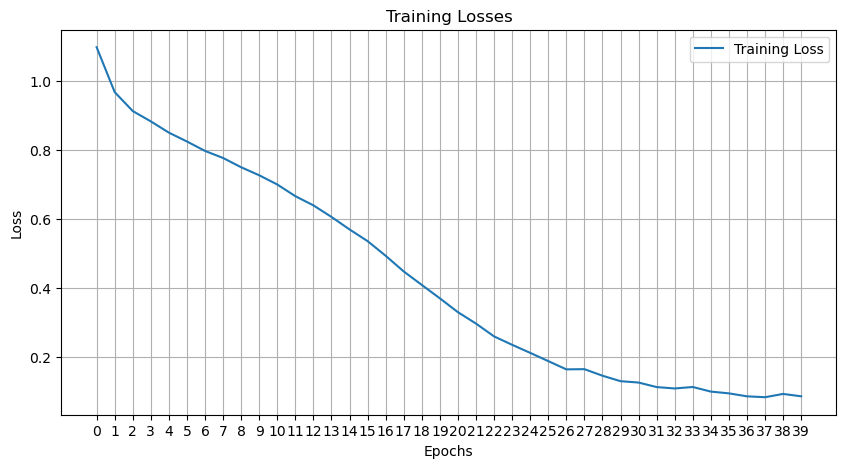

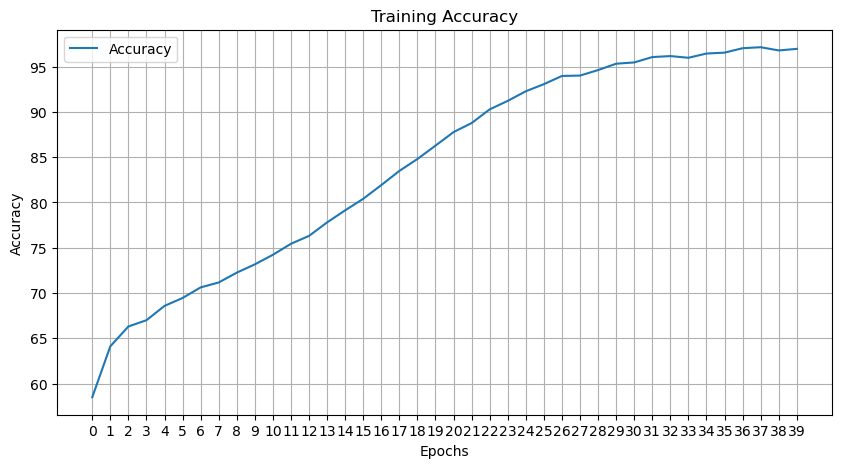

In [64]:
plot_loss_accuracy(training_losses_spec, accuracies_spec)

In [65]:
test_model(model_spec, test_loader_spec, device)

Precision: 0.6328
Recall: 0.6427
F1 Score: 0.6328

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.28      0.34       256
           1       0.78      0.85      0.81       963
           2       0.47      0.59      0.52       362
           3       0.58      0.54      0.56       317
           4       0.59      0.43      0.50       260

    accuracy                           0.64      2158
   macro avg       0.57      0.54      0.55      2158
weighted avg       0.63      0.64      0.63      2158

Test Accuracy: 64.27%


#### Section 4.3 1D Resnet

In [66]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18_1D(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18_1D, self).__init__()

        # Load the pretrained ResNet18 model
        resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first convolution layer to Conv1d (from Conv2d)
        resnet18.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify all Conv2d layers to Conv1d and BatchNorm2d to BatchNorm1d
        self._replace_conv2d_with_conv1d(resnet18)

        # Adjust the average pooling layer to work with 1D
        resnet18.avgpool = nn.AdaptiveAvgPool1d(1)

        # Define the fully connected layer (fc) to match the number of output classes
        resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

        # Store the modified ResNet18 model
        self.resnet18 = resnet18

    def _replace_conv2d_with_conv1d(self, model):
        """Recursively replace Conv2d with Conv1d and BatchNorm2d with BatchNorm1d in all layers of the ResNet18 model."""
        for name, module in model.named_children():
            if isinstance(module, nn.Conv2d):
                # Replace Conv2d with Conv1d
                in_channels = module.in_channels
                out_channels = module.out_channels
                kernel_size = module.kernel_size[0]  # Get the kernel size for 1D
                stride = module.stride[0]  # Get the stride for 1D
                padding = module.padding[0]  # Get the padding for 1D

                # Create new Conv1d layer
                new_conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
                setattr(model, name, new_conv)

            elif isinstance(module, nn.BatchNorm2d):
                # Replace BatchNorm2d with BatchNorm1d
                num_features = module.num_features
                new_bn = nn.BatchNorm1d(num_features)
                setattr(model, name, new_bn)

            elif isinstance(module, nn.MaxPool2d):
                # Replace MaxPool2d with MaxPool1d
                kernel_size = module.kernel_size  
                stride = module.stride 
                padding = module.padding  

                # Create new MaxPool1d layer
                new_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
                setattr(model, name, new_pool)

            # Recursively handle Sequential and ModuleList containers
            elif isinstance(module, nn.Sequential):
                self._replace_conv2d_with_conv1d(module)
            elif isinstance(module, nn.ModuleList):
                for m in module:
                    self._replace_conv2d_with_conv1d(m)
            elif isinstance(module, nn.Module):
                self._replace_conv2d_with_conv1d(module)

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [67]:
model_1d = ResNet18_1D(len(y_train_tensor_clean.unique()))
# Move model to device
model_1d.to(device)
print(model_1d)

ResNet18_1D(
  (resnet18): ResNet(
    (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [68]:
training_losses_1d, accuracies_1d=train_model(model_1d, train_loader_clean_1d, device)

Epoch [1/40], Loss: 0.9295, Accuracy: 66.19%
Epoch [2/40], Loss: 0.8073, Accuracy: 70.41%
Epoch [3/40], Loss: 0.7640, Accuracy: 71.64%
Epoch [4/40], Loss: 0.7408, Accuracy: 72.24%
Epoch [5/40], Loss: 0.7105, Accuracy: 73.37%
Epoch [6/40], Loss: 0.6916, Accuracy: 73.77%
Epoch [7/40], Loss: 0.6782, Accuracy: 74.25%
Epoch [8/40], Loss: 0.6586, Accuracy: 75.02%
Epoch [9/40], Loss: 0.6423, Accuracy: 75.65%
Epoch [10/40], Loss: 0.6293, Accuracy: 75.80%
Epoch [11/40], Loss: 0.6107, Accuracy: 76.77%
Epoch [12/40], Loss: 0.6019, Accuracy: 77.18%
Epoch [13/40], Loss: 0.5786, Accuracy: 78.03%
Epoch [14/40], Loss: 0.5626, Accuracy: 78.40%
Epoch [15/40], Loss: 0.5422, Accuracy: 79.26%
Epoch [16/40], Loss: 0.5114, Accuracy: 80.46%
Epoch [17/40], Loss: 0.4872, Accuracy: 81.28%
Epoch [18/40], Loss: 0.4532, Accuracy: 82.45%
Epoch [19/40], Loss: 0.4127, Accuracy: 83.80%
Epoch [20/40], Loss: 0.3780, Accuracy: 85.46%
Epoch [21/40], Loss: 0.3298, Accuracy: 87.25%
Epoch [22/40], Loss: 0.2846, Accuracy: 89.1

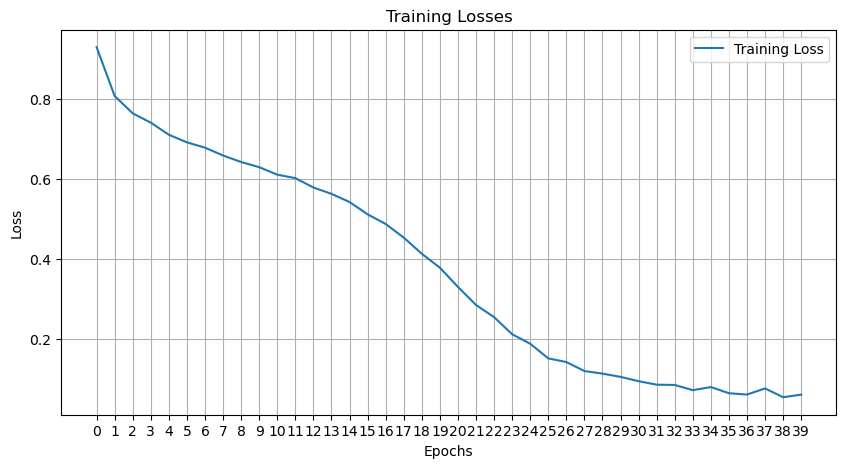

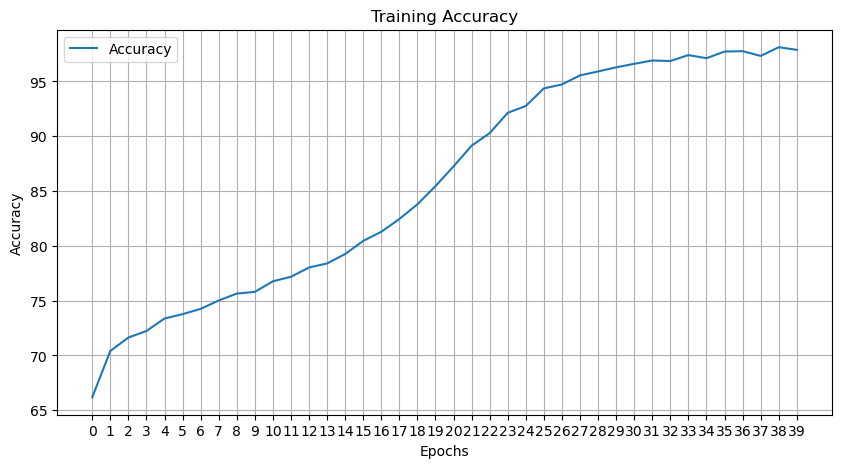

In [69]:
plot_loss_accuracy(training_losses_1d, accuracies_1d)

In [70]:
test_model(model_1d, test_loader_clean_1d, device)

Precision: 0.6662
Recall: 0.6816
F1 Score: 0.6689

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.37      0.44       256
           1       0.78      0.91      0.84       963
           2       0.58      0.58      0.58       362
           3       0.58      0.56      0.57       317
           4       0.56      0.45      0.50       260

    accuracy                           0.68      2158
   macro avg       0.61      0.57      0.59      2158
weighted avg       0.67      0.68      0.67      2158

Test Accuracy: 68.16%
